In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from collections import deque
import random
import yaml
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot
from tqdm import tqdm
from torch.distributions import Categorical

import logging
logging.getLogger('lightning').setLevel(0)

In [2]:
pl.seed_everything(42)

42

## Main part

### Training the r_0 neural network for the specific country

We need to define the size of the window, in terms of days, for which we want to predict the optimal policy set. In our structure, when a set of policy is decided it must be active for at least one week before changing it, for stability reasons. This is reasonable also looking at the real world.

In [3]:
WINDOW_SIZE = 28
assert WINDOW_SIZE % 7 == 0

Now we need to decide on which country we are going to optimize the policy set. We train the reproduction rate network accordingly.

In [4]:
target_country = 'ITA'
data_swissre = pd.read_csv('data/swissre/swissre_data_with_vax.csv', parse_dates=['date']).set_index('date')

In [5]:
# Selecting the features
with open('config/swissre_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)
    
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['to_use'] +\
            swissre_features['vaccines']['to_use'] +\
            swissre_features['policies']['to_use'] +\
            swissre_features['outcomes']['to_use'] + ['cases']

outcome = 'epiforecasts_effective_reproduction_number_median'

df = data_swissre[columns_to_use].copy()

# Taking the data starting from the 1st of april.
df = df[df.index >= '2020-04-01'].sort_index()

In [6]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [7]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 169


In [8]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])
df['r_estim'] = df[outcome]

In [9]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 161


In [10]:
# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic']['to_use'] +\
            swissre_features['vaccines']['to_use'] +\
            swissre_features['policies']['to_use']

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == target_country][col].isnull().all()]
final_train_cols = list(set(final_train_cols) - set(['fiscal_measures', 'emergency_investment_in_health_care', 'investment_in_vaccines']))

In [11]:
context = Context()
pipeline = Pipeline(df, final_train_cols, 'r_estim', target_country, WINDOW_SIZE, context)
pipeline.fit_pipeline(save_model=False)

Training the model...



The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


..................................................................

The mean average error was 0.017135068454383923


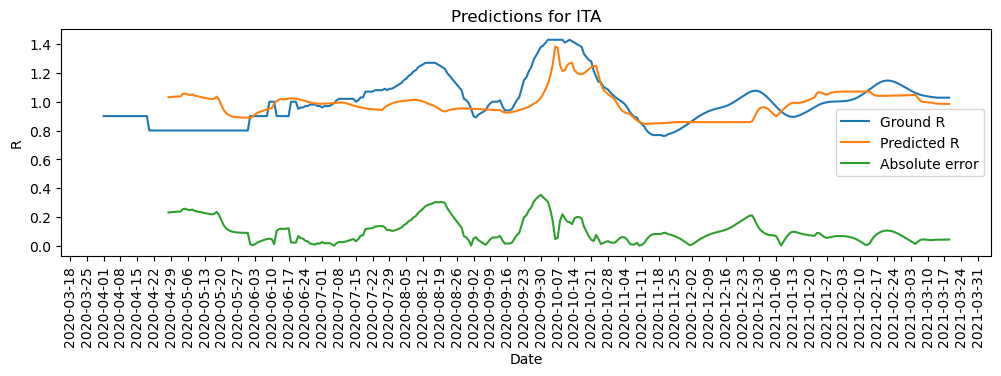

In [33]:
predictions = pipeline.predict()

plot = Plot(df, 'r_estim', target_country, save_path='./plots/') #shifted_r_estim
plot.plot_results(predictions, show = True)

In [13]:
model = pipeline.get_model()
print(pipeline.get_data()[1][1].shape)
print(pipeline.get_data()[1][0].shape)

torch.Size([326, 28, 12])
torch.Size([326, 47])


In [14]:
variable_names = pipeline.get_cols()[1]
variable_names

['cancel_public_events',
 'close_public_transport',
 'contact_tracing',
 'international_travel_controls',
 'public_information_campaigns',
 'restrictions_on_gatherings',
 'restrictions_on_internal_movement',
 'school_closing',
 'stay_at_home_requirements',
 'testing_policy',
 'vaccination_policy',
 'workplace_closing']

In [15]:
# Defining the range of variation for each policy
variation_policy_level = [3, 3, 3, 5, 3, 5, 3, 4, 4, 4, 6, 4]

In [16]:
constant_features= pipeline.get_data()[1][0][-1].numpy()
constant_names = pipeline.get_cols()[0]

**Now we take the last four weeks as the first input for our agent.**

In [23]:
variable_beginning_features = pipeline.get_data()[1][1][-1].numpy()[::7]
initial_state = []
for day in variable_beginning_features:
    initial_state.append(pipeline.get_denorm_data(variable_names, [day]))
initial_state = np.array(initial_state).flatten()

In [24]:
initial_state

array([2., 1., 2., 3., 2., 4., 2., 3., 2., 2., 2., 2., 2., 1., 2., 3., 2.,
       4., 2., 3., 2., 2., 2., 2., 2., 1., 2., 3., 2., 4., 2., 3., 2., 2.,
       2., 3., 2., 1., 2., 3., 2., 4., 2., 3., 2., 2., 2., 3.])

In [34]:
predictions[-1]

0.9847857100020253

In [35]:
pipeline.single_prediction(variable_names, constant_names, np.repeat(initial_state.reshape(4, 12), 7, axis=0), [constant_features], norm_var=True).numpy()[0][0]

0.9847857100020253

## Reinforcement learning

### Policy gradient

In this section we define the structure of the RL agent. It is based on a policy network with the REINFORCE algorithm by Sutton and Barto.

In [143]:
class Policy(nn.Module):
    def __init__(self, state_space, action_space):
        super(Policy, self).__init__(
        )
        self.__model = nn.Sequential(
            nn.Linear(state_space, 128),
            nn.SELU(),
            nn.Linear(128, action_space),
            nn.Softmax(dim=1)
        )

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.__model(x)
        return x
    
class Agent:
    def __init__(self, state_space, action_space, discount, learning_rate):
        self.__state_space = state_space
        self.__action_space = action_space
        self.__discount = discount
        self.__lr = learning_rate
        
        self.__model, self.__optimizer = self.__build_network()
        
        
    def __build_network(self):
        model = Policy(self.__state_space, self.__action_space)
        optimizer = Adam(model.parameters(), lr=self.__lr)
        
        return model, optimizer
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.__model(state)
        m = Categorical(probs)
        action = m.sample()
        self.__model.saved_log_probs.append(m.log_prob(action))

        return action.item()
    
    def observe_reward(self, reward):
        self.__model.rewards.append(reward)
    
    def finish_episode(self):
        R = 0
        policy_loss = []
        returns = []
        for index, r in enumerate(self.__model.rewards[::-1]):
            discount = 1
            if index % 12 == 0:
                discount = self.__discount
            R = r + discount * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns)
        
        for log_prob, R in zip(self.__model.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)
    
        self.__optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.__optimizer.step()
        del self.__model.rewards[:]
        del self.__model.saved_log_probs[:]

### Defining the training phase

In [144]:
def main():
    """
    The number of steps corresponds to the number of weeks that we want to predict
    """
    running_reward = 10    
    state_size =  initial_state.shape[0] +1 #The last number is to define which policy the agent is changing, since it can change one policy at a time.
    number_of_actions = 6
    agent = Agent(state_space=state_size, action_space=number_of_actions, discount=0.99, learning_rate=0.002)
    
    for i_episode in range(30000):
        ep_reward = 0
        
        # We append the last number which is the number of the action we are changin
        current_state = np.append(initial_state, 0)
        last_prediction = predictions[-1]
        
        #print("STARTING NEW EPISODE")
        #print(current_state)
        
        for t in range(int(WINDOW_SIZE / 7)):
    
            #print("STARTING NEW WEEK")
    
            # In each step we need to change one policy at a time to avoid action space explosion
            next_week_policies = []
            for p in range(len(variation_policy_level)):
                current_state[-1] = p
                action = agent.select_action(current_state)
                #action = min(action, variation_policy_level[p]-1)
                next_week_policies.append(action) 

                # We give the agent a reward only at the end of the week
                if p == len(variation_policy_level) -1:
                    # I need to update the state with last week
                    next_state = current_state[:-1] # Excluding the placeholder from the prediction
                    next_state = np.roll(next_state, -12)
                    next_state[-12:] = np.array(next_week_policies)
                    network_input = next_state.reshape(int(WINDOW_SIZE / 7), len(variation_policy_level))
                    network_input = np.repeat(network_input, 7, axis=0)  
                    prediction = pipeline.single_prediction(variable_names, constant_names, network_input, [constant_features], norm_var=True).numpy()[0][0]
                    current_state = np.append(next_state, 0)
                    # Reward logic
                    #r1 = 1 if last_prediction - prediction > 0 else -1
                    #r2 = 1 if prediction < 0 else -1
                    #reward = r1+r2
                    reward = 1 / prediction
                    last_prediction = prediction
                else:
                    reward = 0
                agent.observe_reward(reward)                   
                ep_reward += reward
            
            #print(current_state)
            #print("TOTAL REWARD: ", ep_reward)
            
        #print("\n")
                
                
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward    
        agent.finish_episode()    
        if i_episode % 10 == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
            i_episode, ep_reward, running_reward))
        if i_episode % 50 == 0:
            print('State {}'.format(current_state))

In [145]:
main()

Episode 0	Last reward: 4.58	Average reward: 9.73
State [0. 0. 4. 1. 0. 1. 0. 1. 0. 4. 2. 5. 2. 2. 4. 4. 1. 5. 1. 3. 4. 5. 5. 3.
 1. 5. 0. 0. 0. 5. 1. 3. 5. 0. 3. 3. 4. 5. 3. 4. 0. 1. 4. 2. 1. 0. 4. 1.
 0.]
Episode 10	Last reward: 4.43	Average reward: 7.51
Episode 20	Last reward: 4.27	Average reward: 6.19
Episode 30	Last reward: 4.14	Average reward: 5.36
Episode 40	Last reward: 4.18	Average reward: 4.88
Episode 50	Last reward: 4.05	Average reward: 4.57
State [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.
 0.]
Episode 60	Last reward: 4.19	Average reward: 4.38
Episode 70	Last reward: 4.05	Average reward: 4.30
Episode 80	Last reward: 4.19	Average reward: 4.23
Episode 90	Last reward: 4.10	Average reward: 4.17
Episode 100	Last reward: 4.11	Average reward: 4.14
State [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 2.

KeyboardInterrupt: 

## Alternative to Policy Network: DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.__model = nn.Sequential(
            nn.Linear(state_space, 128),
            nn.ReLU(),
            nn.Linear(128, action_space),
        )
    def forward(self, x):
        return self.__model(x)
    
    
class DQNAgent:
    def __init__(self, learning_rate, discount, epsilon, epsilon_min, decay, tau, batch_size=128):
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay = decay
        self.tau = tau